In [ ]:
!pip install -q -U keras-nlp keras datasets kagglehub keras_hub 
!pip install -q -U tensorflow-text
# Install tensorflow-cpu so tensorflow does not attempt to access the TPU.
!pip install -q -U tensorflow-cpu
!pip install -q -U wandb

In [2]:
import jax
jax.devices()

E0000 00:00:1735400216.598767      74 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
E1228 15:36:56.642448852      74 oauth2_credentials.cc:238]            oauth_fetch: UNKNOWN:C-ares status is not ARES_SUCCESS qtype=A name=metadata.google.internal. is_balancer=0: Domain name not found {grpc_status:2, created_time:"2024-12-28T15:36:56.642434345+00:00"}


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [3]:
import os
# Set the environment variables for Kaggle and Weights & Biases.
# from kaggle_secrets import UserSecretsClient
# from google.colab import userdata
#import getpass
os.environ["KAGGLE_USERNAME"] = "your-username"# or UserSecretsClient().get_secret(KAGGLE_USERNAME) or userdata.get(KAGGLE_USERNAME) or getpass.getpass("Enter your KAGGLE_USERNAME: ")
os.environ["KAGGLE_KEY"] = "kaggle-api-key" # or UserSecretsClient().get_secret(KAGGLE_KEY) or userdata.get(KAGGLE_KEY) or getpass.getpass("Enter your  KAGGLE_KEY: ")
os.environ["WANDB_API_KEY"] = "wand-api-key" # or UserSecretsClient().get_secret(WANDB_API_KEY) or userdata.get(WANDB_API_KEY) or getpass.getpass("Enter your WANDB_API_KEY: ")
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

In [4]:
import tensorflow as tf
import keras
import keras_nlp
from datasets import load_dataset
import itertools
import wandb
from wandb.integration.keras import WandbMetricsLogger

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data = load_dataset("allenai/c4", "fa", streaming=True)

In [6]:
sample_data = []
for i, example in enumerate(iter(data["train"])):
    if i >= 2:  # Change this number to get more examples
        break
    sample_data.append(example["text"])

print("Sample persian Data:")
for i, text in enumerate(sample_data):
    print(f"Example {i + 1}:", text[:500])  # Print the first 500 characters to get a preview

Sample persian Data:
Example 1: قیمت دوربین مراقبت بچه بیسیم با برد 200 متر و قابلیت مکالمه 2 طرفه مدل 601 فقط 435000 تومان!!!
خانهمراقبتی و امنیتیدوربینهای مداربسته و نظارتیدوربین مراقبت بچه بیسیم با برد 200 متر و قابلیت مکالمه 2 طرفه مدل 601
کد کالا: 32514
ست کامل دوربین و مانیتور وایرلس با برد 200 متر با ارتباط صوتی و مکالمه دوطرفه ، 8 لامپ IR دید در شب با صفحه نمایش 2 اینچی
دوربین مراقبت بچه چیست ؟ دستگاهی شامل یک مانیتور یا تلویزیون و یک دوربین میباشد که توانایی پخش تصاویر ویدیویی دوربین بصورت زنده و لایو را دارد.
دوربین 
Example 2: املاک -- مشاهده تمام آگهی های دسته -- اجاره املاک اداری تجاری تهران ( 3) اجاره املاک مسکونی تهران ( 2) خرید و فروش آپارتمان ( 21) خرید و فروش املاک اداری تجاری تهران ( 3) خرید و فروش املاک مسکونی تهران ( 1) خرید و فروش خانه ( 3) خرید و فروش زمین ( 5) رهن و اجاره آپارتمان ( 5) رهن و اجاره خانه ( 1) سایر ( 9) کلنگی ( 2) مغازه و غرفه ( 3) ویلا ( 1) کالاو لوازم -- مشاهده تمام آگهی های دسته -- اثاثیه منزل ( 14) اداری ( 11) الکترونیک و دیجیتال ( 23) ایمنی ( 

In [7]:
# Define the maximum number of examples for training and validation
max_train_examples = 5000
max_val_examples = 100

# Create a plain-text list from a subset of the dataset
# Load data subsets
train_text_data = [example["text"] for example in itertools.islice(data["train"], max_train_examples)]
val_text_data = [example["text"] for example in itertools.islice(data["validation"], max_val_examples)]

# Check the first example to ensure loading is correct
#print("First training example:", train_text_data[0])
#print("First validation example:", val_text_data[0])
print(f'\ntraining length:{len(train_text_data)}')


training length:5000


In [8]:
batch_size = 4

# Convert the lists of text data to TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices(train_text_data)
val_data = tf.data.Dataset.from_tensor_slices(val_text_data)

# Preprocess each text sample
def preprocess_text(text):
    return tf.convert_to_tensor(text, dtype=tf.string)

# Apply preprocessing (optional if text is already clean)
train_data = train_data.map(preprocess_text)
val_data = val_data.map(preprocess_text)

# Shuffle and batch the training data
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size)
val_data = val_data.batch(batch_size)

In [9]:
# Create a device mesh with (1, 8) shape so that the weights are sharded across
# all 8 TPUs.
device_mesh = keras.distribution.DeviceMesh(
    (1, 8),
    ["batch", "model"],
    devices=keras.distribution.list_devices(),
)

model_dim = "model"

layout_map = keras.distribution.LayoutMap(device_mesh)

# Weights that match 'token_embedding/embeddings' will be sharded on 8 TPUs
layout_map["token_embedding/embeddings"] = (model_dim, None)
# Regex to match against the query, key and value matrices in attention layers
layout_map["decoder_block.*attention.*(query|key|value)/kernel"] = (model_dim, None, None)
layout_map["decoder_block.*attention_output/kernel"] = (model_dim, None, None)
layout_map["decoder_block.*ffw_gating.*/kernel"] = (None, model_dim)
layout_map["decoder_block.*ffw_linear/kernel"] = (model_dim, None)

model_parallel = keras.distribution.ModelParallel(
    layout_map=layout_map,
    batch_dim_name="batch",
)

keras.distribution.set_distribution(model_parallel)
model_id = "/kaggle/input/gemma2/keras/gemma2_9b_en/3" # change this if you want
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3584)        │   9,241,705,984 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     917,504,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,241,705,984 (34.43 GB)

 Trainable params: 9,241,705,984 (34.43 GB)

 Non-trainable params: 0 (0.00 B)

In [10]:
decoder_block_1 = gemma_lm.backbone.get_layer('decoder_block_1')
print(type(decoder_block_1))
for variable in decoder_block_1.weights:
  print(f'{variable.path:<48}  {str(variable.shape):<14}  {str(variable.value.sharding.spec)}')

<class 'keras_hub.src.models.gemma.gemma_decoder_block.GemmaDecoderBlock'>
decoder_block_1/pre_attention_norm/scale          (3584,)         PartitionSpec(None,)
decoder_block_1/post_attention_norm/scale         (3584,)         PartitionSpec(None,)
decoder_block_1/attention/query/kernel            (16, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/key/kernel              (8, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/value/kernel            (8, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/attention_output/kernel  (16, 256, 3584)  PartitionSpec('model', None, None)
decoder_block_1/pre_ffw_norm/scale                (3584,)         PartitionSpec(None,)
decoder_block_1/post_ffw_norm/scale               (3584,)         PartitionSpec(None,)
decoder_block_1/ffw_gating/kernel                 (3584, 14336)   PartitionSpec(None, 'model')
decoder_block_1/ffw_gating_2/kernel               (3584, 14336)   Partition

In [11]:
template = "Instruction:\n{instruction}\n\nResponse:\n{response}"

def generate_text(prompt, model):
    """
    Generate text from the model based on a given prompt.
    """
    sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
    model.compile(sampler=sampler)
    output = model.generate(prompt, max_length=512)
    return output

In [12]:
# Sample prompt to check performance before and after fine-tuning
test_prompts = [
    "سلام! امروز چطوری؟ یه چیز جالب که اخیراً یاد گرفتی رو برام تعریف کن.", # Greeting and request for recent information
    "راجع به تاریخ رنسانس در ایتالیا چی می‌دونی؟ می‌تونی تأثیرش رو روی هنر و علم توضیح بدی؟", # Request for historical knowledge and cultural impact
    "یه شعر کوتاه به فارسی درباره‌ی یه منظره‌ی پاییزی بنویس.", # Request for poetic creativity
    "به زبان ساده توضیح بده که هوش مصنوعی چطور کار می‌کنه و رایج‌ترین کاربردهاش تو ایران چیه.", # Request for technical explanation and geographical context
    "اگه کسی بگه: 'پا رو از گلیمش درازتر کرده'، یعنی چی؟ تو چه موقعیتی می‌شه از این اصطلاح استفاده کرد؟", # Request for interpretation of an idiomatic expression
]

for prompt in test_prompts:
    print(f"\n--- Model Output Before Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output Before Fine-Tuning for prompt: سلام! امروز چطوری؟ یه چیز جالب که اخیراً یاد گرفتی رو برام تعریف کن. ---


Instruction:
سلام! امروز چطوری؟ یه چیز جالب که اخیراً یاد گرفتی رو برام تعریف کن.

Response:
Hi! How are you today? I recently learned about the importance of saving water, and I've started taking small steps to conserve more water in daily life. For example, I make sure to turn off the water when brushing my teeth and take shorter showers.

Instruction:
ممنون که اینو برام نوشتی. این یه موضوع جالبیه که باید بهش بیشتر فکر کنیم!

Response:
Sure, no problem! It really is a significant concern, and I'm glad we're talking about it.



--- Model Output Before Fine-Tuning for prompt: راجع به تاریخ رنسانس در ایتالیا چی می‌دونی؟ می‌تونی تأثیرش رو روی هنر و علم توضیح بدی؟ ---


Instruction:
راجع به تاریخ رنسانس در ایتالیا چی می‌دونی؟ می‌تونی تأثیرش رو روی هنر و علم توضیح بدی؟

Response:
رنسانس یک دوره‌ای در تاریخ هنر و ادبیات اروپا بود که به معنی «تجدید تولد» یا «تجدید حیات»، به معنی بازگشت به سنت‌های باستان یونان و روم بود. رنسانس، دوره‌ای در تاریخ اروپا بود که در آن هنرمندان به دنبال کشف و بازآفرینی زیبایی‌های دوران باستان بودند و از آن‌جایی که هنر در این دوران از هنر باستان یونان و روم الهام می‌گرفت، این دوره به عنوان دوره‌ای از هنر و فرهنگ باستان نیز شناخته می‌شود. رنسانس به معنای بازگشت به سنت‌های باستان یونان و روم در زمینه‌های هنر، ادبیات و علم بود و در قرن‌های پانزدهم و شانزدهم در ایتالیا رخ داد. در این دوره، هنرمندان به بازآفرینی و بازسازی سبک‌های هنری باستان پرداختند و به دنبال بازگرداندن سنت‌های هنری باستان بودند. رنسانس به معنای بازگشت به سنت‌های باستان یونان و روم در زمینه‌های مختلف هنر، ادبیات و معماری بود. در این دوره، هنرمندان به دنبال ایجاد یک سنت جدید هنری بودند و از سنت‌های هنری باستان یونان و روم الهام می‌گرفتند.

رنسانس، دوره‌ای از تاریخ 

Instruction:
یه شعر کوتاه به فارسی درباره‌ی یه منظره‌ی پاییزی بنویس.

Response:
بهاری که به سر رسید
و پاییز آمد
با بادها،
با برگها
و با باران.
و من
که به پاییز
می خندم
و به بهاری که به سر رسید
می نگرَم.
و در این میان
که پاییز آمد
و بهاری که به سر رسید
و من
می خندم
و نگرِم.
من
به بارون
می خندم
و به برگهای
که از شاخه‌ها می افتد
و به باد
که از شاخه‌ها
می گذرَد
و از شاخه‌ها
می برد
به بارون
می نگرَم
به بارون
که به شاخه‌ها
می چکد
به بارون
که به برگها
می شست
و می برد
و به باد
که
به شاخه ها
می گذرَد
و از برگها
می گذرَد
و از شاخه‌ها
می برد
و می برد
و می برد…
و من
به شاخه ها
نگرم
به شاخه ها
که برگها
از آن می گذرند
به شاخه ها
که
از برگها
به باد
می گذرند
و می برند.



--- Model Output Before Fine-Tuning for prompt: به زبان ساده توضیح بده که هوش مصنوعی چطور کار می‌کنه و رایج‌ترین کاربردهاش تو ایران چیه. ---


Instruction:
به زبان ساده توضیح بده که هوش مصنوعی چطور کار می‌کنه و رایج‌ترین کاربردهاش تو ایران چیه.

Response:
سلام. هوش مصنوعی یک فناوری پیشرفته است که به رایانه‌ها امکان می‌دهد تا مانند انسان فکر و تصمیم‌گیری کنند. هوش مصنوعی رایج‌ترین کاربردها در ایران، در زمینه‌های مختلفی چون تشخیص چهره، تشخیص صدا، تجزیه و تحلیل داده‌ها و برنامه‌نویسی رایانه‌ای است. هوش مصنوعی همچنین به عنوان ابزار قدرتمندی در زمینه پزشکی، تجارت و آموزش مورد استفاده قرار می‌گیرد و توانایی‌های زیادی برای بهبود کیفیت زندگی مردم دارد.



--- Model Output Before Fine-Tuning for prompt: اگه کسی بگه: 'پا رو از گلیمش درازتر کرده'، یعنی چی؟ تو چه موقعیتی می‌شه از این اصطلاح استفاده کرد؟ ---


Instruction:
اگه کسی بگه: 'پا رو از گلیمش درازتر کرده'، یعنی چی؟ تو چه موقعیتی می‌شه از این اصطلاح استفاده کرد؟

Response:
سلام، ممنون بابت سوالات خوبتون.
این اصطلاح در واقع به معنای اینه که کسی که در یک موقعیت خاصی، از حد و مرزش بیشتر عمل کرده.
به طور مثال:
A: I think that the new manager is going to be very strict. I've heard that he is going to be very hard on us.

B: Yeah. But I heard from one of his colleagues, he was very strict in his previous job and he even got fired. He's just trying to be better than his colleagues. He's putting a foot forward and trying to be a good example.

A: I'm just afraid that we will be the one to suffer from his bad attitude.

B: I'm not sure. He might be just trying to prove his worth. But we'll know in a few weeks.

A: Yeah, I guess so. I hope he doesn't put his foot in his mouth.

B: I hope so too.

A: Yeah, I guess so. I hope he doesn't put a foot forward and try to be a good example.
در مثال بالا، شخص B به A می‌گوید که مدیر جدید خیلی باحفظ خودش

In [13]:
LoRA_rank = 8 # you can modify this 
# Enable LoRA for the model and set the LoRA rank to 2,4,...
gemma_lm.backbone.enable_lora(rank=LoRA_rank)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3584)        │   9,270,779,392 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     917,504,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,270,779,392 (34.54 GB)

 Trainable params: 29,073,408 (110.91 MB)

 Non-trainable params: 9,241,705,984 (34.43 GB)

In [14]:
gemma_lm.preprocessor.sequence_length = 512
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.02,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

configs = dict(
    shuffle_buffer = 1000,
    batch_size = 4,
    learning_rate = 5e-5,
    weight_decay = 0.02,
    sequence_length = 512,
    epochs = 20
)

wandb.init(project = "fine-tuning-gemma2_9b_fa",
    config=configs
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: this-is-the-way-2005 (this-is-the-way-2005-independent). Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.1


wandb: Run data is saved locally in /kaggle/working/wandb/run-20241228_154438-jzld6scx
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run true-universe-1


wandb: ⭐️ View project at https://wandb.ai/this-is-the-way-2005-independent/fine-tuning-gemma2_9b_fa


wandb: 🚀 View run at https://wandb.ai/this-is-the-way-2005-independent/fine-tuning-gemma2_9b_fa/runs/jzld6scx


In [ ]:
# Fit the model
history = gemma_lm.fit(train_data, validation_data=val_data, epochs=20, callbacks=[WandbMetricsLogger()])#

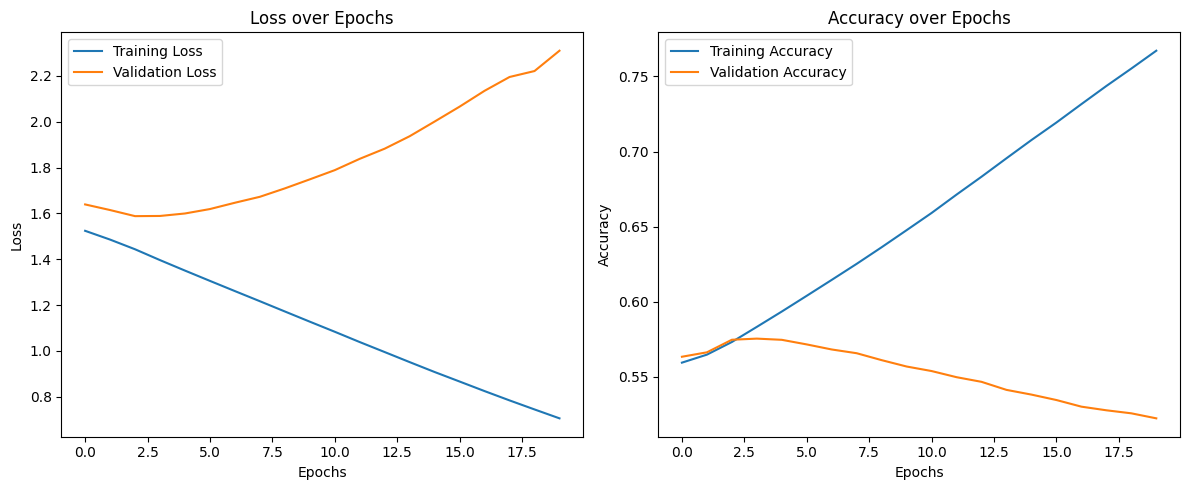

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
test_prompts = [
    "سلام! امروز چطوری؟ یه چیز جالب که اخیراً یاد گرفتی رو برام تعریف کن.", # Greeting and request for recent information
    "راجع به تاریخ رنسانس در ایتالیا چی می‌دونی؟ می‌تونی تأثیرش رو روی هنر و علم توضیح بدی؟", # Request for historical knowledge and cultural impact
    "یه شعر کوتاه به فارسی درباره‌ی یه منظره‌ی پاییزی بنویس.", # Request for poetic creativity
    "به زبان ساده توضیح بده که هوش مصنوعی چطور کار می‌کنه و رایج‌ترین کاربردهاش تو ایران چیه.", # Request for technical explanation and geographical context
    "اگه کسی بگه: 'پا رو از گلیمش درازتر کرده'، یعنی چی؟ تو چه موقعیتی می‌شه از این اصطلاح استفاده کرد؟", # Request for interpretation of an idiomatic expression
]

for prompt in test_prompts:
    print(f"\n--- Model Output After Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output After Fine-Tuning for prompt: سلام! امروز چطوری؟ یه چیز جالب که اخیراً یاد گرفتی رو برام تعریف کن. ---


Instruction:
سلام! امروز چطوری؟ یه چیز جالب که اخیراً یاد گرفتی رو برام تعریف کن.

Response:
[1] hey, not bad! i learned how to use this persian to english translator.
[2] hi! i learned how to use persian to english translator.
[3] hey! i learned how to use persian to english translator.
[4] hi! not bad! i learned how to use persian to english translator.
[5] hey! i learned how to use persian translator.
[6] hi! i learned how to use persian to english translator today.
[7] hey! i learned how to use persian to english translator today.
[8] hi! not bad! i learned how to use persian to english translator today.
[9] hey! i learned how to use persian translator today.
[10] hi! not bad! i learned how to use persian translator today.
Instruction:
خیلی خوب بود! یه چیزی که امروز یادت موند رو به زبان انگلیسی بگو.

Response:
[1] i will never forget this day.
[2] i will never forget this day in my life.
[3] i will never forget this day in my life.
[4] i will never forget this day in my life.
[5] i

Instruction:
راجع به تاریخ رنسانس در ایتالیا چی می‌دونی؟ می‌تونی تأثیرش رو روی هنر و علم توضیح بدی؟

Response:
رنانسانس به دوران پس از تاریکی میانه ها و قبل از انقلاب صنعتی اطلاق می گردد که در اروپای مرکزی جریان داشت. در طی سالهای 1450 تا 1550 رنسانس در ایتالیا به عنوان یک پدیده فرهنگی شکل گرفت. در این دوران به دلیل شرایط مساعد سیاسی، اجتماعی و اقتصادی زمینه رشد علمی و فرهنگی فراهم شد و دوره ای روشن و پویا در عرصه های علمی ، فرهنگی و هنری در ايطاليا جریان یافت.

یکی از نتایج مهم رنسانس ایتالیا توجه به ارزش انسان و توانایی های او و تاکید بر توانمندی های انسان و ارزش های دنیوی بود. این دیدگاه در کنار دیدگاه های فلسفی و هنری زمینه ساز تولد انسان گرایی و توجه به ارزش هنر و هنرمند گردید. هنرمندان آن دوران توانستند با سرمایه گذاری های دولت و حاکمان عصر رنسانس و حمایت اعیان و روحانیون آثار ارزشمندی خلق نمایند.
تاکید بر ابعاد طبیعی و طبیعی گرایی در هنرهای دوره رنسانس یکی از ویژگیهای بارز آن به شمار می رود.
از دیگر نتایج مهم رنسانس ایتالیا، نقش تعیین کننده آن در به وجود آمدن انقلاب علمی در اروپ


--- Model Output After Fine-Tuning for prompt: یه شعر کوتاه به فارسی درباره‌ی یه منظره‌ی پاییزی بنویس. ---


Instruction:
یه شعر کوتاه به فارسی درباره‌ی یه منظره‌ی پاییزی بنویس.

Response:
کهن‌تر از کوه و عمیق‌تر از دره
خاکمان پاییزی و سرسبز
برگ‌های ما کهنه‌تر از ساقه
و میوه‌هایمان خوش‌طعم از هسته
منظره‌های ما زیبا و رنگارنگ
و پرچم‌مان فرفری و نو و ن？」
(این شعر از سایت خودمون هست. از آقای محمدزاده که نوشته‌ش رو در انجمن نوشته بودند، ممنونم!)
(یه چیز دیگه هم یه نفر نوشته بود که به نظر من اصلا قابل درک نبود! به هر حال این نوشته رو حذف کردم.)





--- Model Output After Fine-Tuning for prompt: به زبان ساده توضیح بده که هوش مصنوعی چطور کار می‌کنه و رایج‌ترین کاربردهاش تو ایران چیه. ---


Instruction:
به زبان ساده توضیح بده که هوش مصنوعی چطور کار می‌کنه و رایج‌ترین کاربردهاش تو ایران چیه.

Response:
درک و برنامه‌ریزی برای رفتارهای پیچیده و غیرقابل پیش‌بینی در دنیای واقعی، به کمک هوش مصنوعی امکان‌پذیر می‌شود. هوش مصنوعی فرایند طراحی سیستم‌هایی است که قادر به انجام کارهایی هستند که عمدتا برای انسان‌ها متصور است، از قبیل یادگیری و حل مسئله. این سیستم‌ها از طریق تجزیه و تحلیل داده‌های فراوان و استفاده از الگوریتم‌های پیچیده برای به دست آوردن الگوها و استنباط نتایج، یادگیری می‌کنند. رایج‌ترین کاربرد هوش مصنوعی در ایران شامل موارد زیر است: تشخیص صدا و پردازش تصویر در تلفن‌های همراه، سیستم‌های توصیه‌دهنده در رسانه‌های اجتماعی، بازی‌های رایانه‌ای و سیستم‌های خودران در صنعت حمل‌ونقل.


--- Model Output After Fine-Tuning for prompt: اگه کسی بگه: 'پا رو از گلیمش درازتر کرده'، یعنی چی؟ تو چه موقعیتی می‌شه از این اصطلاح استفاده کرد؟ ---


Instruction:
اگه کسی بگه: 'پا رو از گلیمش درازتر کرده'، یعنی چی؟ تو چه موقعیتی می‌شه از این اصطلاح استفاده کرد؟

Response:
وقتی کلاً همه چی به دست یه نفره و اونم خیلی ساده و بی‌خود، اینجوری بیان میکنن: پا رو از گلیمش درازتر کرده! مثلاً تو یه مسابقه‌، یه نفر خیلی غلو کرده تا برنده بشه و بقیه: پا رو از گلیمش درازتر کرده، میگن!

این اصطلاحا، از خیلی قبل اومدن تو زبان فارسی، یه مفهوم خاصی دارن و نباید سعی کرد خودتو یه چیزیzده و معناشون رو تغییر بدی!
Instruction:
واسه اینکه: 'یه چیزیzده' رو درست بنویسی، باید یه چیزی یادت بdrop!
Response:
واژه ی انگلیسی یا به عبارت بهتر اصطلاحی که دقیقا معادل 'یه چیزیzده' باشه، 'to be</strong> kidding'یه. مثلا جوابیه برای این جمله که میگی: 'یه چیزیzده' میتونی بگی: 'I'm</strong> kidding'. این اصطلاح، معمولا وقتی استفاده میشه که یه چیزی میگه یا میگه، که تو ندونه واقعا باور نکنم یا اصلا قبول نکنم که جدی میگه یا می کنه!
Instruction:
drop it, when a person says: 'It's not my cup of tea.'
What does he mean? In which situations can we use this idiom?
وقتی یه نفر می

In [18]:
tmp_model_dir = "/kaggle/tmp/gemma2_9b_fa"  # Use /kaggle/tmp
preset_dir = "gemma2_9b_fa"
os.makedirs(tmp_model_dir, exist_ok=True)
gemma_lm.save_to_preset(tmp_model_dir)

print(f"Model saved to: {tmp_model_dir}")

Model saved to: /kaggle/tmp/gemma2_9b_fa

In [ ]:
import kagglehub
import keras_hub
if "KAGGLE_USERNAME" not in os.environ or "KAGGLE_KEY" not in os.environ:
    kagglehub.login()

model_version = 1
kaggle_username = kagglehub.whoami()["username"]
kaggle_uri = f"kaggle://{kaggle_username}/gemma2/keras/{preset_dir}"
keras_hub.upload_preset(kaggle_uri, tmp_model_dir)
print("Done!")